In [2]:
from abc import ABC, abstractmethod
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [3]:
class EVDStrategyBacktest(ABC):
    
    
    @abstractmethod
    def process(self):
        """
        Function that processes the daily input and returns the number of units of the asset that the back-tester should 
        purchase given a positive decision. 
        If no position is to be taken, the function should return 0.
        """
        pass
    
    @abstractmethod
    def monitorPosition(self, data, position):
        """
        Takes input of price and position to monitor. Checks if current price is greater than the target price of 
        the position. 
        
        Requires input of:
            - position to monitor
            - current price (in the "data" variable - data variable contains row of that day's
            new data)
            
        The output of running this function is: 
            - True if the position has hit it's target and needs to be closed
            - False if the position has not hit it's target and must remain open
        """
    
        # checking if current price is greater than the position's target
        if data.Price.values[0] > position.PosTarget.values[0]:
                    
            # return True - positive that position needs to be exited
            return True
        
        # checking negative condition (stoploss)
        if data.Price.values[0] < position.NegTarget.values[0]:
            
            # return True - positive that position needs to be exited
            return True
        
        else:
            # return False - neither condition met, position is not to be exited
            return False
    
    @abstractmethod
    def backtest(self):
        """
        This function simulates the actions taken on each respective day of the trading strategy.
        The variable "data_row" contains all the necessary trading information to take a decision
        each day. 
        
        Transaction costs are applied in this function depending on whether they are greater than or
        less than 1; the former treated as absolute, the latter as a %. 
        
        Trades Initialised -> Trades Monitored/Updated -> Cash Value Updated
        """
            
        pass
    
    @abstractmethod
    def openPosition(self, price, units, date, target_price = None):
        """
        Standardised function across strategy backtest classes that takes input of:
        - next day's Open price
        - number of units
        - next day's date
        - optional target price
        
        and returns a dataframe containing all the relevant information contained with an open position.
        To be called within backtest() and created open positions should be appended to self.openPositions.
        """
        
        # ORDER PARAMETERS
        status = True # order status
        position_id = len(self.openPositions) # position identifier
        num_units = units # units of stock to buy
        entry_price = price
        entry_date = date # date of purchase
        pos_val = num_units * entry_price # calculating value of position (pre transaction cost)
    
        # returning a pandas dataframe
        return pd.DataFrame([[status, position_id, num_units, entry_price, entry_date, target_price, pos_val]], 
                            columns=["Status", "PosID", "Units", "EntryPrice", "EntryDate", "Target", "PosVal"])
    
    @abstractmethod
    def closePosition(self, position, price, date):
        """
        Standardised function that takes input of:
            - an open order
            - the next day's open price (day which the transaction is undertaken)
            - the next day's date
            
        and returns a closed position - which is to be appended to the list self.closedPositions, in class
        method backtest(). 
        """
        
        position["Status"] = False # updating the position status 
        position["ExitPrice"] = price # exit price
        position["ExitDate"] = date # exit date
        position["CashGainLoss"] = position["ExitPrice"] - position["EntryPrice"] # calculating cash gain/loss
        position["PercGainPreTC"] = position["CashGainLoss"]/position["EntryPrice"]
        position["WinLoss"] = np.sign(position["CashGainLoss"])
        
        # add more metrics - continue adding over time based on necessary statistics
    
        return position
    
    @abstractmethod
    def updatedCash(self, data):
        """
        Outputs the current cash value of the portfolio by summating the product of the current 
        day's close price and the total units held with the available cash after all positions have 
        been opened/closed.
        """
        
        # Calculating current cash value of portfolio
        tmp_cash = self.cash_available + self.totalUnits()*data.Price.values[0]
    
        return tmp_cash
    
    @abstractmethod
    def totalUnits(self):
        """
        Function returns total units held in open positions.
        """
        
        # counter
        total_units = 0
        
        # iterating through each open position
        for position in self.openPositions:
            
            # adding up all the units in total units
            total_units += int(position.Units.values)
    
        return int(total_units)
    


In [21]:
class BullHighBreakout(EVDStrategyBacktest):
    
    """
    This is an example of an Event Driven Strategy to back-test to. Positions will be taken and closed 
    based on price series data. 
    5% (variable) positions of the overall cash are taken when the close price is greater than the
    200 day MA and less than the 7 Day MA.  
    
    Input data columns should contain:
    - MLTI: Medium-Long Term Indicator
    - STTI: Short Term Trade Indicator
    - PosTarget: A value for which a trade opened on that particular day is trying to exit at 
    - Price: Current Day's Close Price on which analysis is being taken - "process price"
    - Date: Current Date
    - NDOPen: Next Day Open - the price on which any trade decisions will be taken - "purchase price"
    - NDDate: Next Day's date: used to store the date of the next day (the day any trade decisions take place)
    """
    
    def __init__(self, data, start_cash, pos_size, tc, cooldown=1, cash_buffer=0):
        self.data = data # storing the data as a class variable
        self.start_cash = int(start_cash) # storing a specific variable for starting cash
        self.cash_available = start_cash # storing starting cash in a constantly updated variable
        self.cash_buffer = int(cash_buffer*self.start_cash) # option buffer amount
        self.cash_time_series = np.array([float(start_cash)]) # initialises a time series of the internal portfolio's cash value
        self.units_held = np.array([int(0)])
        self.openPositions = list() # or can make this dictionary (?) with date timestamp as key
        self.closedPositions = list() # or can make this dictionary (?) with date timestamp as key
        self.pos_size = pos_size
        self.tc = tc # transaction costs
        self.cooldown = cooldown # initialising cooldown to 0 so that a trades can occur
        
    def process(self, data):
        """
        Takes input data which includes: 
        - a Medium to Long Term Indicator (MLTI)
        - a Short Term Trend Indicator (STTI)
        
        in a pandas Dataframe.
        
        This function runs through the logic behind initialising a trade for this strategy. 
        The variable MTLI is a 200 day MA. The variable STTI is a 7 day MA. 
        
        The Logic for opening positions:
        
        - If the price is greater than the MLTI, we proceed
        - If the price is below the 7 day MA (trending low), proceed 
        - If cash after position opens is greater than buffer: 
            - return num_units: indicating output of the decision process is positive, open a position with number
            of units equal to num_units in backtest()
        """
        
        # long term condition satisfied e.g > 200 day MA
        if data.Price.values[0] > data["MLTI"].values[0]:
            
            # short term condition satisfied: < e.g < 7 day MA
            if data.Price.values[0] < data["STTI"].values[0]:
                
                # calculate number of units
                num_units = int(np.floor((self.pos_size * self.cash_available) / data.Price.values[0]))
                
                # cash check - acts as a lid on opening new positions
                if (self.cash_available - num_units*data.Price.values[0]) > self.cash_buffer:
                    
                    return num_units
                
                else:
                    return 0
            
        return 0

    
    def monitorPosition(self, data, position):
        """
        Takes input of price and position to monitor. Checks if current price is greater than the target price of 
        the position. 
        
        Requires input of:
            - position to monitor
            - current price (in the "data" variable - data variable contains row of that day's
            new data)
            
        The output of running this function is: 
            - True if the position has hit it's target and needs to be closed
            - False if the position has not hit it's target and must remain open
        """
        
                
        # checking if current price is greater than the position's target
        if data.Price.values[0] >= position.PosTarget.values[0]:
                    
            # return true
            return True
        
        # checking if price is less than stoploss
        elif data.Price.values[0] <= position.StopLoss.values[0]:
            return True
        
        else:
            return False

    
    def backtest(self):
        """
        This function simulates the actions taken on each respective day of the trading strategy.
        The variable "data_row" contains all the necessary trading information to take a decision
        each day. 
        
        Transaction costs are applied in this function depending on whether they are greater than or
        less than 1; the former treated as absolute, the latter as a %. 
        
        Trades Initialised -> Trades Monitored/Updated -> Cash Value Updated
        """
        
        # start the cooldown value as 0 so trading can commence from day 1
        cooldown = 0
        
        # running through each day with all available information required in data_row
        for i in range(0, len(self.data)):
            
            # all data required for that day's trade processing
            data_row = self.data.iloc[i:i+1, :]
            
            # decrement cooldown as a new day has started - cooldown is the max of 0 and its current value decremented 
            # this ensures cooldown never goes below 0 
            cooldown = max(0, cooldown - 1)
            
            # verifying that cooldown period has ended before checking to initialise a trade
            if cooldown == 0: 
                
                # 1 TRADE INITIALISATION: if a trade is to be placed
                if self.process(data_row) is not 0:

                    # obtain number of units
                    num_units = self.process(data_row)

                    # OPEN a position
                    self.openPositions.append(self.openPosition(data_row.NDOpen.values[0], num_units, data_row.NDDate.values[0], data_row.PosTarget.values[0], data_row.StopLoss.values[0]))

                    # set the cooldown threshold to the initialised value once a position is opened
                    cooldown = self.cooldown 

                    # reducing the portfolio's cash
                    if self.tc >= 1:
                        self.cash_available = self.cash_available - num_units*data_row.NDOpen.values[0] - self.tc

                    elif self.tc < 1:
                        self.cash_available = self.cash_available - num_units*data_row.NDOpen.values[0] - num_units*data_row.NDOpen.values[0]*self.tc

            
            # 2 TRADE MONITORING: monitoring activate trades by 
            # creating a false bool that turns true when an order closes
            order_closed = False
            
            #iterating throughe each open position
            for position in self.openPositions: 
                
                # checking if exit condition is met in self.monitorPosition()
                if self.monitorPosition(data_row, position) == True:
                    
                    # update order close bool - indicating that an order has closed today
                    order_closed = True
                    
                    # append the closed position to the closed Positions list
                    self.closedPositions.append(self.closePosition(position, data_row.NDOpen.values[0], data_row.NDDate.values[0]))
                    
                    # update the status of the open position
                    position = self.changePositionStatus(position)
                    
                    # update cash and charge transaction costs for closing position
                    if self.tc >= 1:
                        # need to add cash back after absolute transaction costs
                        self.cash_available = self.cash_available + position.Units.values[0]*data_row.NDOpen.values[0] - self.tc
                    
                    elif self.tc < 1:
                        # need to add cash back after % transaction costs
                        self.cash_available = self.cash_available + position.Units.values[0]*data_row.NDOpen.values[0] - position.Units.values[0]*data_row.NDOpen.values[0]*self.tc
                        
             
            # if an order(s) has closed, remove inactive orders is called
            if order_closed:
                
                # self.removeInactiveOrders() removes all inactive orders and returns list of only active order 
                # result stored in self.openPositions
                self.openPositions = self.removeInactiveOrders()
                    
            
            # UPDATING CASH
            self.cash_time_series = np.append(self.cash_time_series, self.updatedCash(data_row))
            self.units_held = np.append(self.units_held, self.totalUnits())
            
        # run desired statistics on list of closed positions 
        
        # return
        return True
        
    
    def openPosition(self, price, units, date, target_price = None, stoploss = None):
        """
        Standardised function across strategy backtest classes that takes input of:
        - next day's Open price
        - number of units
        - next day's date
        - optional target price
        
        and returns a dataframe containing all the relevant information contained with an open position.
        To be called within backtest() and created open positions should be appended to self.openPositions.
        """
        
        # ORDER PARAMETERS
        status = True # order status
        position_id = len(self.openPositions) # position identifier
        num_units = units # units of stock to buy
        entry_price = price
        entry_date = date # date of purchase
        pos_val = num_units * entry_price # calculating value of position (pre transaction cost)

        # returning a pandas dataframe
        return pd.DataFrame([[status, position_id, num_units, entry_price, entry_date, target_price, stoploss, pos_val]], 
                            columns=["Status", "PosID", "Units", "EntryPrice", "EntryDate", "PosTarget", "StopLoss", "PosVal"])
    
    def closePosition(self, position, price, date):
        """
        Standardised function that takes input of:
            - an open order
            - the next day's open price (day which the transaction is undertaken)
            - the next day's date
            
        and returns a closed position - which is to be appended to the list self.closedPositions, in class
        method backtest(). 
        """
        
        position["Status"] = False # updating the position status 
        position["ExitPrice"] = price # exit price
        position["ExitDate"] = date # exit date
        position["CashGainLoss"] = position["Units"]*(position["ExitPrice"] - position["EntryPrice"]) # calculating cash gain/loss
        position["PercGainPreTC"] = position["CashGainLoss"]/(position["Units"]*position["EntryPrice"])
        position["WinLoss"] = np.sign(position["CashGainLoss"])
        
        # add more metrics - continue adding over time based on necessary statistics
        
        return position
    
    def totalUnits(self):
        """
        Function returns total units held in open positions.
        """
        
        # counter
        total_units = 0
        
        # iterating through each open position
        for position in self.openPositions:
            
            # adding up all the units in total units
            total_units += int(position.Units.values[0])
            
        return int(total_units)
    
    def changePositionStatus(self, position):
        """
        Turns a position's status from True to False. Is called whenever an open order is closed. 
        """
        
        position.Status = False
        
        
        return position
    
    def removeInactiveOrders(self):
        """
        Function that iterates through the list of open positions and copies all active positions into a new list
        and updates the class variable to that list i.e. removing all inactive open positions.
        
        This function works in tandem with self.changePositionStatus() - it is to be run in backtest() after each position
        has been scanned.
        """
        
        # temporary list to store all active positions
        tmp = []
        
        # while the size of the open positions list is at least 1
        while len(self.openPositions) >= 1:
            
            # pop each position off
            position = self.openPositions.pop()
            
            # if the position is active then store it in the temporary list
            if position.Status.values == True:
                tmp.append(position)
        
        return tmp
    
    def updatedCash(self, data):
        """
        Outputs the current cash value of the portfolio by summating the product of the current 
        day's close price and the total units held with the available cash after all positions have 
        been opened/closed.
        """
        
        # Calculating current cash value of portfolio
        tmp_cash = self.cash_available + self.totalUnits()*data.NDOpen.values[0]
        
        return tmp_cash
    
    def return_pos_df(self):
        """
        Returns a dataframe containing key details of all the closed positions. This function is to be run 
        after the backtest() function when self.closedPositions contains all closed positions. 
        """

        # setting positions_dfequal to first closed position dataframe accessed via class variable
        self.pos_df = self.closedPositions[0]

        # iterating through each position from the second onwards
        for i, pos in enumerate(self.closedPositions, start=1):

            # enumerate goes till i equals the size of list, hence a break condition is in place to trigger on last iteration
            if i == len(self.closedPositions): break

            # appending next row to positions_dfdf    
            self.pos_df = self.pos_df.append(strat.closedPositions[i]) 

        # sorting by date entered
        self.pos_df = self.pos_df.sort_values("EntryDate")

        return self.pos_df
        
    

## Getting Data into the Right Format

In [10]:
lite = yf.Ticker("LITE").history(period="30y")
tsla = yf.Ticker("TSLA").history(period="30y")
aapl = yf.Ticker("AAPL").history(period="30y")

stoploss = 0.1

data = aapl[6000:]

data = data.rename(columns={"Close": "Price"}) # getting current day close in right format for class input

ndopen = data["Open"].shift(-1) # next day open - purchase price
nddate = data.index.values[1:] # tmp array for next day dates

data = data[["Price", "Open"]] # process price
data["StopLoss"] = data["Price"] * (1 - stoploss)

data["NDOpen"] = ndopen # initialising purchase price
data = data.dropna() # dropping nan to make space for date[1:] values converted into datetime values 
data["NDDate"] = pd.to_datetime(nddate)

# calculate smaller averages first
data["STTI"] = data["Price"].rolling(5).mean()
data["PosTarget"] = data["Price"].rolling(5).max()
data["MLTI"] = data["Price"].rolling(200).mean()

data = data.dropna()
data.head(5)

,Price,Open,StopLoss,NDOpen,NDDate,STTI,PosTarget,MLTI
Date,,,,,,,,
2016-05-11,21.573040,21.799241,19.415736,21.622013,2016-05-12,21.672383,21.785250,24.927104
2016-05-12,21.067003,21.622013,18.960303,20.987717,2016-05-13,21.537128,21.785250,24.891466
2016-05-13,21.108978,20.987717,18.998080,21.545058,2016-05-16,21.434522,21.785250,24.856484
2016-05-16,21.892521,21.545058,19.703269,22.048761,2016-05-17,21.485358,21.892521,24.826128
2016-05-17,21.801571,22.048761,19.621414,21.957817,2016-05-18,21.488623,21.892521,24.796540


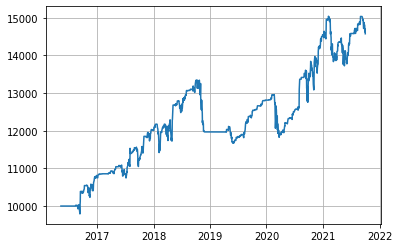

In [19]:
strat = BullHighBreakout(data, 10000, 0.1, 2, 1)
strat.backtest()

plt.plot(data["NDDate"].values, strat.cash_time_series[1:])
plt.grid()

In [20]:
strat.return_pos_df()

,Status,PosID,Units,EntryPrice,EntryDate,PosTarget,StopLoss,PosVal,ExitPrice,ExitDate,CashGainLoss,PercGainPreTC,WinLoss
0,False,0,39,25.270113,2016-08-12,25.511606,22.774751,985.534404,25.703863,2016-08-16,16.916271,0.017165,1.0
0,False,1,35,25.354518,2016-08-15,25.511606,22.827508,887.408128,25.703863,2016-08-16,12.227092,0.013778,1.0
0,False,0,39,25.460025,2016-08-23,25.645248,22.897144,992.940956,26.695629,2016-09-15,48.188580,0.048531,1.0
0,False,1,35,25.455340,2016-08-24,25.640556,22.968886,890.936908,26.695629,2016-09-15,43.410111,0.048724,1.0
0,False,2,32,25.178674,2016-08-25,25.640556,22.795858,805.717562,26.695629,2016-09-15,48.542570,0.060248,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,False,1,9,147.440002,2021-08-20,151.119995,132.029997,1326.960022,152.660004,2021-08-31,46.980011,0.035404,1.0
0,False,2,8,148.309998,2021-08-23,151.119995,133.371002,1186.479980,152.660004,2021-08-31,34.800049,0.029330,1.0
0,False,3,7,148.350006,2021-08-26,149.710007,133.524001,1038.450043,152.660004,2021-08-31,30.169983,0.029053,1.0
0,False,4,6,147.479996,2021-08-27,149.710007,132.785994,884.879974,152.660004,2021-08-31,31.080048,0.035123,1.0


In [22]:
aapl

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1991-10-02,0.377879,0.377879,0.361449,0.363274,17987200,0.0,0.0
1991-10-03,0.365101,0.365101,0.346845,0.348671,181003200,0.0,0.0
1991-10-04,0.350496,0.355973,0.346845,0.352322,79374400,0.0,0.0
1991-10-07,0.350496,0.355973,0.346845,0.351409,64702400,0.0,0.0
1991-10-08,0.351409,0.354147,0.339544,0.352322,172256000,0.0,0.0
...,...,...,...,...,...,...,...
2021-09-27,145.470001,145.960007,143.820007,145.369995,74150700,0.0,0.0
2021-09-28,143.250000,144.750000,141.690002,141.910004,108972300,0.0,0.0
2021-09-29,142.470001,144.449997,142.029999,142.830002,74602000,0.0,0.0


# To-Do
1. Incorporate statistics script into a function and put in class
2. Keeping track of trades per certain period "N" e.g. weekly (N=5), monthly (N=20) etc.
3. Weekly/ Monthly Var/CVar
4. Method to adjust POSITION SIZE based on how well strategy is performing 

2) Keeping track of trades per certain period "N" e.g. weekly (N=5), monthly (N=20) etc. in order to have a "max executions per period" 
- In backtest() add an if statement that conditions whether or not self.process runs
- Have a lookback script that opens self.openPositions and self.closedPositions and counts the number of orders that occured between the current date - last N days 
- if the number of trades in the last N days >= defined max_executions (for whatever period) then don't initiate a new trade

In [16]:
# function to output dataframe of closed positions

def return_pos_df():
    """
    Returns a dataframe containing key details of all the closed positions. This function is to be run 
    after the backtest() function when self.closedPositions contains all closed positions. 
    """
    
    # setting positions_dfequal to first closed position dataframe accessed via class variable
    positions_df = strat.closedPositions[0]

    # iterating through each position from the second onwards
    for i, pos in enumerate(strat.closedPositions, start=1):
        
        # enumerate goes till i equals the size of list, hence a break condition is in place to trigger on last iteration
        if i == len(strat.closedPositions): break
            
        # appending next row to positions_dfdf    
        positions_df = positions_df.append(strat.closedPositions[i]) 
    
    # sorting by date entered
    positions_df = positions_df.sort_values("EntryDate")
    
    return positions_df


def no_weekends(date1, date2):
    
    # generating dates
    dates = (date1 + timedelta(1 + idx)
             for idx in range((date2 - date1).days))

    # summing all weekdays
    res = sum(1 for day in dates if day.weekday() < 5)

    # getting number of weekends
    weekends = int((date2 - date1).days) - res
    
    # return number of weekends / non-business days
    return weekends

## Functions Required for calculating backtest statistics below

In [8]:
def ret(pos_time_series):
    """
    This function takes in a numpy array repreenting a price time series. It outputs the return time series. 
    """
    rets = np.delete((shift(pos_time_series, -1) - pos_time_series)/pos_time_series, -1)
    return rets

def max_dd(data):
    """
    This function returns the max drawdown of an input price series. 
    """
    
    # obtains the index of the minimum point in the time series 
    p = np.argmax(np.maximum.accumulate(data) - data)

    # in the event there is no drawdown
    if p == 0:
        return 0, 0
    
    else:
        # obtaining the maximum point prior to p 
        q = np.argmax(data[:p])
        
        # calculating the drawdown: absolute value and percentage
        max_dd_abs = np.round(data[q] - data[p], 3)
        max_dd_perc = np.round((data[p]-data[q])/data[q], 3)
        
        # returning max drawdown to 3 decimal places
        return max_dd_abs, max_dd_perc

def calc_exposure(positions):
    """
    This function calculates the exposure of the trading strategy. It requires the class attribute self.pos_df which contains 
    a dataframe with each closed position as a row, holding all the main information regarding that closed position. It returns
    a decimal value for the exposure. 
    """

    # maintaining temporary variables for each exposure interval
    curr_exp_start = 0
    curr_exp_end = 0
    curr_exp = 0

    # initialising starting exposure variables
    curr_exp_start = positions.iloc[0, :].EntryDate
    curr_exp_end = positions.iloc[0, :].ExitDate
    curr_exp = int((curr_exp_end - curr_exp_start).days)

    # list for maintaing integers of exposure intervals
    exp_int = []


    for i in range(1, len(positions)):

        # checking if the new position was OPENED BEFORE the closing of the previous position (overlap)
        if positions.iloc[i, :].EntryDate <=  positions.iloc[i-1, :].ExitDate:
            pass

        # condition triggered when new position is OEPNED AFTER the close of the previous position
        # an exposure interval has ended and variables must be re-assigned 
        else: 
            
            # appending previous exposure interval to list
            exp_int.append(curr_exp)
            
            # updating current exposure start and end dates
            curr_exp_start = positions.iloc[i, :].EntryDate
            curr_exp_end = positions.iloc[i, :].ExitDate
            
            # subtracting weekends
            curr_exp = int((curr_exp_end - curr_exp_start).days) - no_weekends(curr_exp_start, curr_exp_end)

        # checking if the new position CLOSED AFTER close of the previous position (extend exposure)
        if positions.iloc[i, :].ExitDate >  positions.iloc[i-1, :].ExitDate:
            curr_exp_end = positions.iloc[i, :].ExitDate

        # condition triggered when new position closes BEFORE close of the previous position
        else:
            pass
    
    # subtracting weekends and setting exposure equal to sum of exposed periods divided by total days between dataset 
    # start and end dates with weekends / non-business days subtracted
    exposure = round(np.sum(exp_int)/(int((data.index[-1] - data.index[0]).days) - no_weekends(data.index[0], data.index[-1])), 2)
    
    # return exposure as percentage decimal
    return exposure

# transaction costs of portfolio - need to use self.tc in the class
def total_tcost():
    """
    Calculates the total transaction costs paid throughout the backtesting of the portfolio. 
    """
    
    tc = 2
    
    total_tc = 0

    if tc >= 1:
        # transaction cost for every completed order during opening and closing (hence x2)
        total_tc = (len(strat.closedPositions) * 2 * tc) + (len(strat.openPositions) * tc)

    else:
        for position in strat.closedPositions:
            total_tc += (position.EntryPrice.values[0]*position.Units.values[0]*tc) + (position.ExitPrice.values[0]*position.Units.values[0]*tc)

        for position in strat.openPositions:
            total_tc += (position.EntryPrice.values[0]*position.Units.values[0]*tc)
            
    return total_tc

## Backtest Statistics Function
- Put this into a function
- Look at "return_pos_df()" and see if there is a vectorised way you can calculate some of these quantities instead so that you don't have to repeat calculations since you need metrics like "holding time" in the pos_df dataframe

In [15]:
# statistics function


# initialising variables that will be used as counters
avg_perc_ch = 0
avg_bars_held = 0
avg_amount_ch = 0

winners = 0
avg_win_bars_held = 0
avg_winner_perc = 0
win_prof = 0
consec_wins = 0
max_consec_wins = 0
big_win = 0

losers = 0
avg_lose_bars_held = 0
avg_loser_perc = 0
lose_prof = 0
consec_losses = 0
max_consec_losses = 0
big_loss = 0

for position in strat.closedPositions:
    
    avg_perc_ch += 100*position.PercGainPreTC.values[0]
    avg_bars_held += (position.ExitDate[0]  - position.EntryDate[0]).days
    avg_amount_ch += position.CashGainLoss.values[0] 
    
    # winner stats calculations
    winners += 1 if position.WinLoss.values[0] == 1 else int(0)
    avg_win_bars_held += (position.ExitDate[0]  - position.EntryDate[0]).days if position.WinLoss.values[0] == 1 else int(0)
    avg_winner_perc += 100*position.PercGainPreTC.values[0] if position.WinLoss.values[0] == 1 else int(0)
    win_prof += position.CashGainLoss.values[0] if position.WinLoss.values[0] == 1 else int(0)
    consec_wins = consec_wins + 1 if (position.WinLoss.values[0] == 1) else int(0)
    max_consec_wins = max(max_consec_wins, consec_wins)
    big_win = max(big_win, position.CashGainLoss.values[0] if position.WinLoss.values[0] == 1 else int(0))
    
    # loser stats calculations
    losers += 1 if position.WinLoss.values[0] == -1 else int(0)
    avg_lose_bars_held += (position.ExitDate[0]  - position.EntryDate[0]).days if position.WinLoss.values[0] == -1 else int(0)
    avg_loser_perc += 100*position.PercGainPreTC.values[0] if position.WinLoss.values[0] == -1 else int(0)
    lose_prof += position.CashGainLoss.values[0] if position.WinLoss.values[0] == -1 else int(0)
    consec_losses = consec_losses + 1 if position.WinLoss.values[0] == -1 else int(0)
    max_consec_losses = max(max_consec_losses, consec_losses)
    big_loss = min(big_loss, position.CashGainLoss.values[0] if position.WinLoss.values[0] == -1 else int(0))
    
    # position specific calculations 
    pos_time_series = data[position.EntryDate.values[0]:position.ExitDate.values[0]]["Open"].values * position.Units.values[0]
    position["Max DD Value"], position["Max DD Return"] = max_dd(pos_time_series)
    position["Holding Time"] = (position.ExitDate[0]  - position.EntryDate[0]).days
    
positions = return_pos_df()

# back-test stats
init_cap = strat.cash_time_series[0]
end_cap = strat.cash_time_series[-1]
total_net_prof = (end_cap - init_cap)
net_prof_perc = total_net_prof/init_cap
exposure = calc_exposure(return_pos_df())
ann_ret = (1 + net_prof_perc)**(252/len(data)) - 1
trans_costs = total_tcost()
port_max_dd_val, port_max_dd_perc = max_dd(strat.cash_time_series)

# total trade stats
total_trades = len(strat.closedPositions)
avg_amount_ch = avg_amount_ch/len(strat.closedPositions)
avg_perc_ch = avg_perc_ch/len(strat.closedPositions)
avg_bars_held = avg_bars_held/len(strat.closedPositions)
avg_dd_abs = positions["Max DD Value"].mean()
avg_dd_perc = positions["Max DD Return"].mean()
max_dd_abs = positions["Max DD Value"].max()
max_dd_perc = positions["Max DD Return"].min()

# winner stats
winners = winners
win_perc = round(winners/len(strat.closedPositions), 2)
avg_win_prof = win_prof/winners
avg_winner_perc = avg_winner_perc/winners
avg_win_bars_held = avg_win_bars_held/winners
max_consec_wins = max_consec_wins
big_win_bars_held = (positions[positions["CashGainLoss"] == big_win].ExitDate - positions[positions["CashGainLoss"] == big_win].EntryDate)[0].days

# loser stats
losers = losers 
lose_perc = round(losers/len(strat.closedPositions), 2)
avg_lose_prof = lose_prof/losers
avg_loser_perc = avg_loser_perc/losers
avg_lose_bars_held = avg_lose_bars_held/losers
max_consec_losses = max_consec_losses
big_loss_bars_held = (positions[positions["CashGainLoss"] == big_loss].ExitDate - positions[positions["CashGainLoss"] == big_loss].EntryDate)[0].days

columns = ["Initial Capital", "Ending Capital", "Total Profit", "Total Profit Percentage", "Exposure", "Annual Return", "Transaction Costs", "Portfolio Max DD Value", "Portfolio Max DD Perc",
           "Total Trades", "Avg Gain/Loss", "Avg Percentage Gain/Loss", "Avg Bars Held", "Avg Max DD Value", "Avg Max DD Percentage", "Max DD Trade Value", "Max DD Trade Percentage",
           "Winners", "Win Percentage", "Win Profits", "Avg Win Profit", "Avg Win Percentage", "Avg Win Bars Held", "Max Consecutive Wins", "Biggest Win", "Biggest Win Bars Held", 
           "Losers", "Lose Percentage", "Loss Losses", "Avg Lose Profit", "Avg Lose Percentage", "Avg Lose Bars Held", "Max Consecutive Losses", "Biggest Loss", "Biggest Loss Bars Held"]

stats = pd.DataFrame([[init_cap, end_cap, total_net_prof, net_prof_perc, exposure, ann_ret, trans_costs, port_max_dd_val, port_max_dd_perc,
              total_trades, avg_amount_ch, avg_perc_ch, avg_bars_held, avg_dd_abs, avg_dd_perc, max_dd_abs, max_dd_perc, 
              winners, win_perc, win_prof, avg_win_prof, avg_winner_perc, avg_win_bars_held, max_consec_wins, big_win, big_win_bars_held,
              losers, lose_perc, lose_prof, avg_lose_prof, avg_loser_perc, avg_lose_bars_held, max_consec_losses, big_loss, big_loss_bars_held]], 
             columns=columns)

stats

,Initial Capital,Ending Capital,Total Profit,Total Profit Percentage,Exposure,Annual Return,Transaction Costs,Portfolio Max DD Value,Portfolio Max DD Perc,Total Trades,...,Biggest Win Bars Held,Losers,Lose Percentage,Loss Losses,Avg Lose Profit,Avg Lose Percentage,Avg Lose Bars Held,Max Consecutive Losses,Biggest Loss,Biggest Loss Bars Held
0,10000.0,14818.399809,4818.399809,0.48184,0.67,0.07571,1774,1674.719,-0.125,439,...,10,55,0.13,-4360.878537,-79.288701,-8.946143,16.436364,17,-248.235386,9


## VaR and CVaR

In [237]:
def var(alpha):
    """
    Calculates the historical daily value at risk of the portfolio. The steps taken are:
    - calculate the returns of the portfolio
    - sort the returns
    - find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
    - return the VAR value
    """

    # calculate the returns of the portfolio
    p_ret = ret(strat.cash_time_series)

    # sort the returns
    sorted_p_ret = np.sort(p_ret)[::-1]

    # find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
    a_idx = int(np.round(alpha * len(p_ret)))

    # VAR value
    Var = sorted_p_ret[a_idx]
    
    return Var

def cvar(alpha):
    """
    Calculates the historical daily Conditional Value at Risk (or Expected Shortfall). The steps taken are:
    - calculate the returns of the portfolio
    - sort the returns
    - find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
    - take the average of the values of returns that are below the var value corresponding the alpha'th index 
    """
    # calculate the returns of the portfolio
    p_ret = ret(strat.cash_time_series)

    # sort the returns
    sorted_p_ret = np.sort(p_ret)[::-1]

    # find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
    a_idx = int(np.round(alpha * len(p_ret)))

    # calculates CVar/Expected Shortfall (ES) by taking the average of the worst 1 - alpha % of cases
    CVar = np.mean(sorted_p_ret[a_idx:])
    
    return CVar 

In [32]:
positions.tail(10)

,Status,PosID,Units,EntryPrice,EntryDate,PosTarget,StopLoss,PosVal,ExitPrice,ExitDate,CashGainLoss,PercGainPreTC,WinLoss,Max DD Value,Max DD Return,Holding Time
0,False,7,5,146.199997,2021-08-09,147.139542,131.525999,730.999985,148.970001,2021-08-13,13.850021,0.018947,1.0,1.95,-0.003,4
0,False,8,4,146.440002,2021-08-10,147.139542,131.480997,585.760010,148.970001,2021-08-13,10.119995,0.017277,1.0,1.56,-0.003,3
0,False,9,4,146.050003,2021-08-11,146.839996,131.040005,584.200012,148.970001,2021-08-13,11.679993,0.019993,1.0,0.00,0.000,2
0,False,10,3,146.190002,2021-08-12,146.839996,131.274001,438.570007,148.970001,2021-08-13,8.339996,0.019016,1.0,0.00,0.000,1
0,False,0,10,145.029999,2021-08-19,151.119995,131.724001,1450.299988,152.660004,2021-08-31,76.300049,0.052610,1.0,23.30,-0.016,12
0,False,1,9,147.440002,2021-08-20,151.119995,132.029997,1326.960022,152.660004,2021-08-31,46.980011,0.035404,1.0,20.97,-0.016,11
0,False,2,8,148.309998,2021-08-23,151.119995,133.371002,1186.479980,152.660004,2021-08-31,34.800049,0.029330,1.0,18.64,-0.016,8
0,False,3,7,148.350006,2021-08-26,149.710007,133.524001,1038.450043,152.660004,2021-08-31,30.169983,0.029053,1.0,6.09,-0.006,5
0,False,4,6,147.479996,2021-08-27,149.710007,132.785994,884.879974,152.660004,2021-08-31,31.080048,0.035123,1.0,0.00,0.000,4
0,False,5,6,149.000000,2021-08-30,149.710007,133.740005,894.000000,152.660004,2021-08-31,21.960022,0.024564,1.0,0.00,0.000,1


In [42]:
positions

,Status,PosID,Units,EntryPrice,EntryDate,PosTarget,StopLoss,PosVal,ExitPrice,ExitDate,CashGainLoss,PercGainPreTC,WinLoss,Max DD Value,Max DD Return,Holding Time
0,False,0,39,25.270107,2016-08-12,25.511608,22.774749,985.534181,25.703860,2016-08-16,16.916344,0.017165,1.0,0.000,0.000,4
0,False,1,35,25.354520,2016-08-15,25.511608,22.827502,887.408194,25.703860,2016-08-16,12.226893,0.013778,1.0,0.000,0.000,1
0,False,0,39,25.460023,2016-08-23,25.645245,22.897140,992.940882,26.695633,2016-09-15,48.188801,0.048531,1.0,54.315,-0.055,23
0,False,1,35,25.455338,2016-08-24,25.640558,22.968884,890.936841,26.695633,2016-09-15,43.410309,0.048724,1.0,48.580,-0.055,22
0,False,2,32,25.178674,2016-08-25,25.640558,22.795857,805.717562,26.695633,2016-09-15,48.542691,0.060248,1.0,39.389,-0.049,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,False,1,9,147.440002,2021-08-20,151.119995,132.029997,1326.960022,152.660004,2021-08-31,46.980011,0.035404,1.0,20.970,-0.016,11
0,False,2,8,148.309998,2021-08-23,151.119995,133.371002,1186.479980,152.660004,2021-08-31,34.800049,0.029330,1.0,18.640,-0.016,8
0,False,3,7,148.350006,2021-08-26,149.710007,133.524001,1038.450043,152.660004,2021-08-31,30.169983,0.029053,1.0,6.090,-0.006,5
0,False,4,6,147.479996,2021-08-27,149.710007,132.785994,884.879974,152.660004,2021-08-31,31.080048,0.035123,1.0,0.000,0.000,4


## Executions Per Period (for analysis)

<StemContainer object of 3 artists>

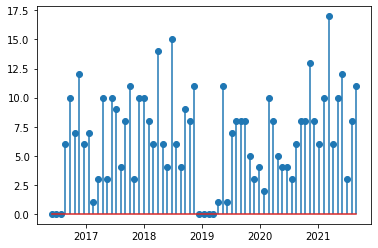

In [63]:
def exec_per_period(data, positions, period):

    executions_per_period = []
    executions_this_period = 0
    last_week = 0
    pos_idx = 0
    date_idx = []

    for i, date in enumerate(data.index):

        if pos_idx == len(positions):
            break

        if date == positions.iloc[pos_idx, :].EntryDate:
            executions_this_period += 1
            pos_idx += 1

        if i - last_week >= period:
            executions_per_period.append(executions_this_period)
            date_idx.append(date)
            executions_this_period = 0
            last_week = i
            
    return executions_per_period, date_idx

e, d = exec_per_period(data, positions, 20)
plt.stem(d, e)

# Allocation Strategy Back-Tester
Inputs:
- Input DataFrame containing all the prices that will be traded
- Dictionary of weight allocations with trade case as key of dictionary, each row of weights structured as:
        - case 0 : w_cash | w_price1 | w_price2 | ... | w_pricen
        - case 1 : cash | price1 | price2 | ... | pricen
        - and so on...
        
- Signal containing unique use cases - logic of signal (i.e. -1, 0, 1 representing ordinally better situations) must remain consistent

Functionality:
- Allocate different weights to different prices (incl cash) based on the trade case 
- Accept either 2 or 3 trade cases (think about higher trade cases too)
- Discrete assets 
- initially split cash into exact allocations but then treat re-allocations;
    - storing a variable tracking total cash value of strategy
    - by ordering the wealths of each
    - redistributing the biggest one first by filling the smallest first
    - incorporate transaction costs for redistributing -> will be difficult

In [81]:
samp = tsla["Close"]

samp.head()




Date
2010-06-29    4.778
2010-06-30    4.766
2010-07-01    4.392
2010-07-02    3.840
2010-07-06    3.222
Name: Close, dtype: float64

In [83]:
# write a function that takes a price series between two desired dates in a dataframe/series and a cash value (float) and 
# replicates that price series scaled to that cash value

def scale(price, amount):
    
    num_units = int(np.floor(amount/price[0]))
    
    scaled_series = num_units*price.values
    
    scaled_series = pd.DataFrame(scaled_series).set_index(price.index)
    
    scaled_series.index = price.index
    
    return scaled_series, num_units
    
    
# define a function that returns the number of units to buy (+ve) / sell (-ve) based on:
    # - current price
    # - the current number of units
    # - target allocation cash amount: should be derived using a tracker of total port cash val and the allocation defined 
    # in the dictionary
    
def units_to_transact(price, units, target):
    
    curr_amount = price*units
    
    required = target - curr_amount
    
    if np.sign(required) == 1:
        
        return np.floor(required/price)
        
    if np.sign(required) == -1:
        
        return np.ceil(required/price)

In [ ]:
# historical example 

w = np.zeros(np.shape(price))
    cash = np.zeros(np.shape(price))
    cash[0] = 10000

    for i in range(0, len(price)):

        if i == len(price)-1:
            break

        if signal[i] == 1: 
            w[i+1] = cash[i]/price[i]  + w[i]
            cash[i+1] = 0

        elif signal[i] == 0:
            cash[i+1] = w[i]*price[i] + cash[i]
            w[i+1] = 0
            
    strat = [a*b for a,b in zip(w[:-1], price)] + cash[:-1]
    
    return strat